# CCA with WordVectors

## Import EEG

In [1]:
import numpy as np
import mne
import os
import scipy.io as sio
import matplotlib.pyplot as plt
def load_eeg(fname, story_order):
    event_id = dict(story_onset=12, boundary=-1)
    raw = mne.io.read_raw_eeglab(fname, preload=True, event_id=event_id)
    raw_eeg = raw.copy().pick_types(eeg=True)
    n_channels = len(raw_eeg.ch_names)
    info = raw_eeg.info
    story_order_1kHz = mne.event.read_events(story_order)
    story_order_125Hz = story_order_1kHz.copy()
    for i in range(len(story_order_125Hz)):
        story_order_125Hz[i,0] = story_order_125Hz[i,0]/8
    return raw_eeg, story_order_125Hz, n_channels, info

p = 4       # participant
set_path = np.load(os.path.join(os.getcwd(), "../../../../set_path.npy"))
order_path = np.load(os.path.join(os.getcwd(), "../../../../story_order_path.npy"))
no_participants = len(set_path)
raw_eeg = []
story_order_125Hz = []
raw_eegs, story_order_125Hzs, n_channels, info = load_eeg((os.path.join(os.getcwd(),"../../../../",set_path[p])), (os.path.join(os.getcwd(),"../../../../",order_path[p])))
raw_eeg.append(raw_eegs.filter(1,6, h_trans_bandwidth=2))
story_order_125Hz.append(story_order_125Hzs)
sfreq =  info['sfreq']

<ipython-input-1-210e3aa4000f>:8: DeprecationWarning: stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning
  raw = mne.io.read_raw_eeglab(fname, preload=True, event_id=event_id)


Used Annotations descriptions: ['boundary', 'story_onset']
Setting up band-pass filter from 1 - 6 Hz
l_trans_bandwidth chosen to be 1.0 Hz
Filter length of 413 samples (3.304 sec) selected


C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\mne\annotations.py:315: RuntimeWarning: invalid value encountered in less
  out_of_bounds = (absolute_onset > tmax) | (absolute_offset < tmin)
C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\mne\annotations.py:324: RuntimeWarning: invalid value encountered in greater
  clip_right_elem = (absolute_offset > tmax) & ~out_of_bounds
<ipython-input-1-210e3aa4000f>:8: RuntimeWarning: 1 events will be dropped because they occur on the same time sample as another event. `mne.io.Raw` objects store events on an event channel, which cannot represent two events on the same sample. Please use `read_annotations_eeglab` and create events using `events_from_annotations` to extract the original event structure. Then, you can e.g. subset the extracted events for constructing epochs.
  raw = mne.io.read_raw_eeglab(fname, preload=True, event_id=event_id)


## Load WordVectors

In [2]:
from scipy.io import wavfile
from scipy import signal
from sklearn.preprocessing import scale
def get_env():
    story_name_path = sio.loadmat(os.path.join(os.getcwd(), "../../../../story_name_path.mat"))['story_name_loc']            
    sfreq = 125
    envelopes = [];
    for i in range(15):
        envelope, time = load_env(story_name_path[i], sfreq)
        envelope = np.reshape(scale(envelope.T),(len(envelope),1))
        envelopes.append(envelope)        
    return envelopes

def load_env(fname, sfreq):
    fs, data = wavfile.read(os.path.join(os.getcwd(), "../../../../",fname))
    time = np.linspace(0., len(data)/fs, len(data))
    data = abs(data)
    speech = signal.decimate(x=data, q=int(fs/sfreq), ftype='fir')
    b, a = signal.butter(3, 0.12, 'low')
    speech = signal.filtfilt(b, a, speech)
    return speech, time

envelopes = get_env()

C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of 

C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\scipy\signal\signaltools.py:2383: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[keep]
C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]
C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of 

## Order EEG according to envelope

In [3]:
def all_eeg_ordered(raw_eeg, story_order_125Hz, envelopes, no_participants):
    all_raw_stories = []
    all_times = []
    speech_duration = np.zeros((15,1))
    for n in range(1):
        raw_stories = []
        times = []
        for i in range(15):
            raw_story, time = get_eeg_ordered(raw_eeg[n],story_order_125Hz[n],envelopes[i],i)
            raw_stories.append(raw_story.T)
            times.append(time)
            speech_duration[i] = len(envelopes[i]) 
        all_raw_stories.append(raw_stories)
        all_times.append(times)
    return all_raw_stories, speech_duration

def get_eeg_ordered(raw_eeg, story_order_125Hz, envelope, story_no):
    raw_story, times = raw_eeg[:,story_order_125Hz[story_order_125Hz[:,2]==story_no][0][0]:(story_order_125Hz[story_order_125Hz[:,2]==story_no][0][0]+len(envelope))]
    return raw_story, times

stories, speech_duration = all_eeg_ordered(raw_eeg, story_order_125Hz, envelopes, no_participants)

## Load WordVectors

In [4]:
from pyeeg.io import WordLevelFeatures
wo_path = os.path.join(os.getcwd(), "../../../..", np.load(os.path.join(os.getcwd(), "../../../../word_onsets_path.npy"))[p])
wv_path = os.path.join( os.getcwd(), '../../../../../WordVectors/vectors_correct_header.txt')
wf = WordLevelFeatures(path_wordonsets=wo_path, path_wordvectors=wv_path)
setattr(wf, 'duration', np.sum(speech_duration)/125)

C:\Users\Karen\AppData\Local\conda\conda\envs\mne\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
INFO:pyeeg.io:Word flushington not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word careering not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word we're not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word i'm not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word beggars not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word we're not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word i've not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word haven't not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word dears not in word embedding model; will use rdm instead
INFO:pyeeg.io:Word lunching not in word embedding model; will use rdm instead
INFO

In [5]:
feat_matrix = wf.align_word_features(features=['wordvectors'], srate=125, wordonset_feature=False)

In [6]:
feat_matrix = feat_matrix[:, :50]

In [7]:
# only necessary if only 1 feature
#feat_matrix = feat_matrix.reshape((len(feat_matrix),1))
feat_matrix.shape

(297772, 50)

## Run CCA modelling

In [8]:
x = feat_matrix[:-1]
y = np.concatenate(stories[0])

In [9]:
from pyeeg.cca import CCA_Estimator
times = np.linspace(-0.2,0.8,46)
cca = CCA_Estimator(times=times, srate=info['sfreq'])
cca.fit(x, y, thresh_x=0.999, thresh_y=0.999, normalise=False, feat_names=["WordVectors"])    # best to use all components but only display first few

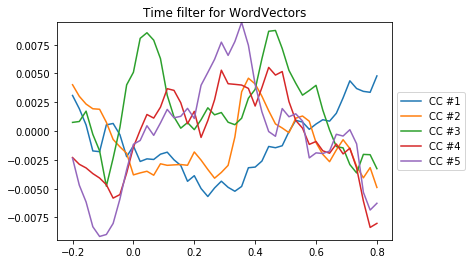

In [10]:
cca.plot_time_filter(n_comp=5, feat_id=0)

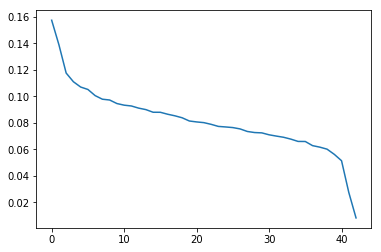

In [11]:
plt.plot(cca.score_)

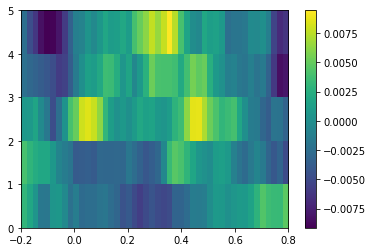

In [12]:
cca.plot_spect(n_comp=5,feat_id=0)

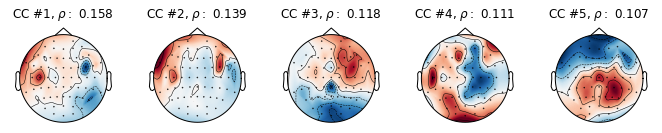

In [13]:
cca.plot_activation_map(info, n_comp=5)

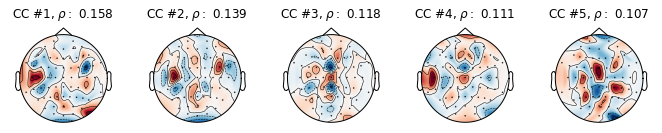

In [14]:
cca.plot_spatial_filter(info, n_comp=5)

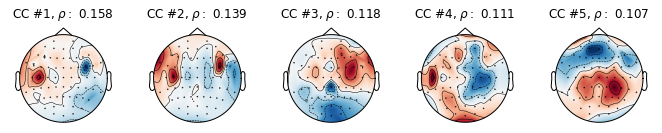

In [15]:
cca.plot_corr(info, n_comp=5)

In [16]:
from pyeeg.vizu import topoplot_array

0.03363133306693847
0.0005929580860187135
0.016083409487541493
0.01825308092110067
0.02254155405215863


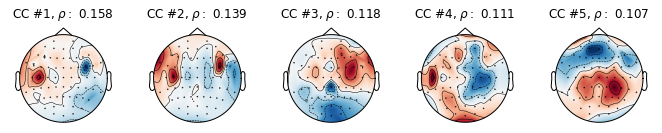

In [17]:
n_comp=5
feat_id=0
r = np.zeros((64,n_comp))
for c in range(n_comp):
    eeg_proj = cca.y @ cca.coefResponse_[:, c]
    env_proj = cca.X[:,:,feat_id] @ cca.coefStim_[:, feat_id, c]
    for i in range(64):
        r[i,c] = np.corrcoef(cca.y[:,i], eeg_proj)[0,1]
    cc_corr = np.corrcoef(eeg_proj, env_proj)[0,1]
    print(cc_corr)
topoplot_array(r, info, n_topos=n_comp, titles=cca.score_)
mne.viz.tight_layout()
